In [55]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred): 
     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
History_Data = pd.read_excel('Competition data.xlsx', sheet_name= 'History Data')

History_Data = History_Data.dropna()
History_Data['Accumulated Day'] = 0

temp_day = 0
def fill_in_DayinWeek (x):
    global temp_day
    if x['Hour'] == 1:
        temp_day = temp_day + 1
    return temp_day
History_Data['Accumulated Day'] = History_Data.apply(fill_in_DayinWeek, axis = 1)
History_Data['Day in Week'] = History_Data['Accumulated Day'] % 7

History_Data['AbsT'] = np.abs(History_Data['T'] - 74.0)

In [57]:
History_Data['Load_kW'].mean()

333397.9618309002

In [3]:
%%time

for time_in_day in [0,2,4,6,8,10,12,14,16,18,20,22]:
    for day_in_week in [0, 1, 2, 3, 4, 5, 6]:

        tempDF_hour = History_Data.loc[History_Data['Hour'].isin([time_in_day+ 1,time_in_day+ 2]) ,:] 
        tempDF_hour_day = tempDF_hour.loc[tempDF_hour['Day in Week'].isin([day_in_week]),:]
        
        begin_time_in_day = time_in_day+ 1
        end_time_in_day = time_in_day+ 2
        
        temp_name = 'Day' + '' + str(day_in_week) + 'inWeek_' + str(begin_time_in_day) + '-' + str(end_time_in_day)
        tempDF_hour_day.loc[:,temp_name] = 1
        History_Data = pd.merge(History_Data, tempDF_hour_day[[temp_name]], left_index= True, right_index= True,\
                                how='outer')
        History_Data = History_Data.fillna(0)

        temp_name2 = 'T*' + temp_name
        History_Data[temp_name2] = History_Data[temp_name] *  History_Data['T']
        
        temp_name3 = 'AbsT*' + temp_name
        History_Data[temp_name3] = History_Data[temp_name] *  History_Data['AbsT']

/Users/yifengwang/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/yifengwang/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


CPU times: user 1min 9s, sys: 10.5 s, total: 1min 20s
Wall time: 13.9 s


In [4]:
train=History_Data.iloc[0:17520,:]
test=History_Data.iloc[17520:26303,:]

In [5]:
test.shape

(8783, 261)

In [69]:
from sklearn.linear_model import LinearRegression

X_train = train.drop('Load_kW', axis = 1)
y_train = train['Load_kW']
X_test = test.drop('Load_kW', axis = 1)
y_test = test['Load_kW']

reg = LinearRegression().fit(X_train, y_train)

y_predict = reg.predict(X_test)
rms = sqrt(mean_squared_error(y_predict, y_test))
print(rms)
mape = mean_absolute_percentage_error(y_predict, y_test)
print(mape)

63400.787635746565
14.27626738859263


In [18]:
test.head(3)

,Year,Month,Day,Hour,T,Load_kW,Accumulated Day,Day in Week,AbsT,Day0inWeek_1-2,...,AbsT*Day3inWeek_23-24,Day4inWeek_23-24,T*Day4inWeek_23-24,AbsT*Day4inWeek_23-24,Day5inWeek_23-24,T*Day5inWeek_23-24,AbsT*Day5inWeek_23-24,Day6inWeek_23-24,T*Day6inWeek_23-24,AbsT*Day6inWeek_23-24
17520,2004,1,1,1,46.0,251611.0,731,3,28.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17521,2004,1,1,2,45.0,246499.0,731,3,29.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17522,2004,1,1,3,43.0,239736.0,731,3,31.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
test2.head(3)

,Year,Month,Day,Hour,Load_kW
17520,2003.0,1.0,1.0,1.0,205874.0
17521,2003.0,1.0,1.0,2.0,190513.0
17522,2003.0,1.0,1.0,3.0,176767.0


In [11]:
History_Data_1year_after = History_Data.shift(365*24)
History_Data_1year_after = History_Data_1year_after[['Year', 'Month','Day','Hour', 'Load_kW']]

In [13]:
test2 = History_Data_1year_after.iloc[17520:26303,:]

# Ensemble Model

In [61]:

for alpha in list(np.arange(0, 1, 0.05)):
   
    y_ensemble = alpha * y_predict + (1 - alpha) * test2['Load_kW']
    rms = sqrt(mean_squared_error(y_ensemble, y_test))
    mape = mean_absolute_percentage_error(y_ensemble, y_test)
    rms = round(rms, 2)
    mape = round(mape, 2)
    #print('alpha', alpha)
    print( 'RMSE', rms, 'MAPE', mape)

RMSE 83807.96 MAPE 17.48
RMSE 80840.17 MAPE 16.67
RMSE 77987.94 MAPE 15.97
RMSE 75264.39 MAPE 15.35
RMSE 72683.99 MAPE 14.81
RMSE 70262.51 MAPE 14.35
RMSE 68016.94 MAPE 13.96
RMSE 65965.23 MAPE 13.64
RMSE 64126.0 MAPE 13.37
RMSE 62518.01 MAPE 13.17
RMSE 61159.49 MAPE 13.02
RMSE 60067.38 MAPE 12.92
RMSE 59256.41 MAPE 12.88
RMSE 58738.21 MAPE 12.9
RMSE 58520.58 MAPE 12.96
RMSE 58606.86 MAPE 13.07
RMSE 58995.71 MAPE 13.23
RMSE 59681.22 MAPE 13.43
RMSE 60653.34 MAPE 13.68
RMSE 61898.56 MAPE 13.96


In [49]:

for alpha in [0.6]:
    y_ensemble = alpha * y_predict + (1 - alpha) * test2['Load_kW']
    rms = sqrt(mean_squared_error(y_ensemble, y_test))
    mape = mean_absolute_percentage_error(y_ensemble, y_test)
    rms = round(rms, 2)
    mape = round(mape, 2)
    print('alpha', alpha)
    print( 'RMSE', rms, 'MAPE', mape)

alpha 0.6
RMSE 59256.41 MAPE 12.88


/Users/yifengwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


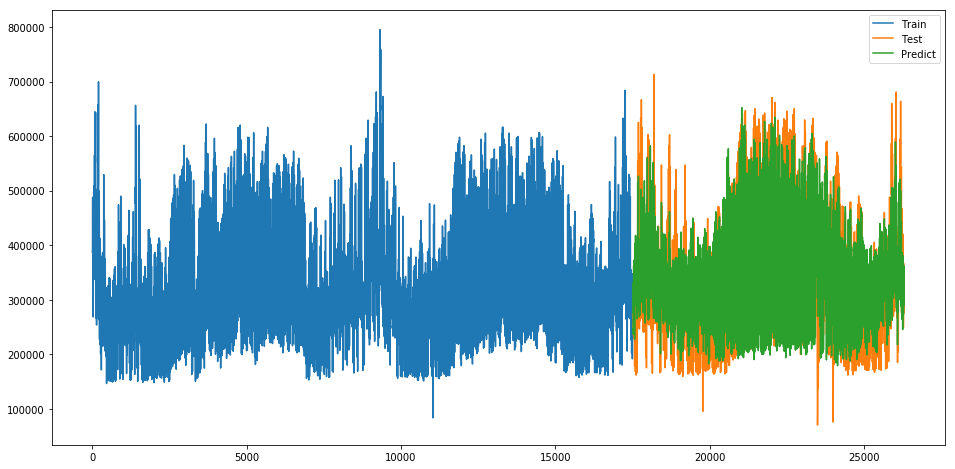

In [50]:
y_hat_avg = test[['Load_kW']]
y_hat_avg['Predict'] = y_ensemble
plt.figure(figsize=(16,8))

y_hat_avg = y_hat_avg.dropna()

plt.plot(train['Load_kW'], label='Train')
plt.plot(y_hat_avg['Load_kW'], label='Test')
#plt.plot(testActual['Load_kW'], label='Test Actual')
plt.plot(y_hat_avg['Predict'], label='Predict')
plt.legend(loc='best')
plt.show()